In [ ]:
firstTime = True
if firstTime:
    print("First time setup")
    %pip install IPython
    %pip install pandas
    %pip install numpy
    %pip install tqdm
    %pip install scikit-learn
    %pip install torch
    %pip install matplotlib
    %pip install seaborn
    %pip install tabulate
    %pip install ipywidgets
    %pip install --upgrade ipywidgets
    %pip install --upgrade jupyter
    firstTime = False

In [2]:
# importing datasets
import pandas as pd
import numpy as np
from tabulate import tabulate
books_raw_df = pd.read_csv('data/Books.csv')
book_ratings_raw_df = pd.read_csv('data/Ratings.csv')
books_users_raw_df = pd.read_csv('data/Users.csv')

C:\Users\elley\AppData\Local\Temp\ipykernel_11828\4274114819.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_raw_df = pd.read_csv('data/Books.csv')


In [3]:
# printing the shape of the dataframes
print(f'Books dataframe shape: {books_raw_df.shape}')
print(f'Reviews dataframe shape: {book_ratings_raw_df.shape}')
print(f'Users dataframe shape: {books_users_raw_df.shape}')

print(tabulate(books_raw_df.head(), headers='keys', tablefmt='psql'))
print(tabulate(book_ratings_raw_df.head(), headers='keys', tablefmt='psql'))
print(tabulate(books_users_raw_df.head(), headers='keys', tablefmt='psql'))

Books dataframe shape: (271360, 8)
Reviews dataframe shape: (1149780, 3)
Users dataframe shape: (278858, 3)
+----+------------+----------------------------------------------------------------------------------------------------+----------------------+-----------------------+----------------------------+--------------------------------------------------------------+--------------------------------------------------------------+--------------------------------------------------------------+
|    |       ISBN | Book-Title                                                                                         | Book-Author          |   Year-Of-Publication | Publisher                  | Image-URL-S                                                  | Image-URL-M                                                  | Image-URL-L                                                  |
|----+------------+----------------------------------------------------------------------------------------------------+

In [4]:
# Size of sampled data
num_books = 100
num_total_ratings = 200

# Data Loading

# Get the top n books (sorted by ISBN)
top_rated_books = book_ratings_raw_df['ISBN'].value_counts().head(num_books).index
sampled_books_df = books_raw_df[books_raw_df['ISBN'].isin(top_rated_books)]

# Loading all ratings for the books
# Create temp df that only has book_isbn of the sampled books
book_ISBN = sampled_books_df['ISBN'].unique()
full_ratings_df = book_ratings_raw_df[book_ratings_raw_df['ISBN'].isin(book_ISBN)]
sampled_ratings_df = full_ratings_df.groupby('ISBN').head(num_total_ratings)

# Merge ratings with users df to get the age of the user
sampled_ratings_df = pd.merge(sampled_ratings_df, books_users_raw_df, on='User-ID', how='left')

# Data cleaning - drop unnecessary columns
sampled_books_df = sampled_books_df.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'])

sampled_ratings_df = sampled_ratings_df.dropna(subset=['Age'])
sampled_ratings_df = sampled_ratings_df.drop(columns=['Location'])

# Print the head row of each dataframe
print(tabulate(sampled_books_df.head(1), headers='keys', tablefmt='psql'))
print(tabulate(sampled_ratings_df.head(1), headers='keys', tablefmt='psql'))

book_titles = sampled_books_df.set_index('ISBN')['Book-Title'].to_dict()
num_total_books = sampled_books_df['ISBN'].nunique()
num_total_users = sampled_ratings_df['User-ID'].nunique()
num_total_ratings = sampled_ratings_df['Book-Rating'].count()

print(f'Sampled Books dimensions: {sampled_books_df.shape}')
print(f'Sampled Ratings dimensions: {sampled_ratings_df.shape}')

print(f'Total books: {num_total_books}')
print(f'Total ratings: {num_total_ratings}')
print(f'Total users: {num_total_users}')

+----+------------+---------------+---------------+-----------------------+-------------+
|    |       ISBN | Book-Title    | Book-Author   |   Year-Of-Publication | Publisher   |
|----+------------+---------------+---------------+-----------------------+-------------|
| 18 | 0440234743 | The Testament | John Grisham  |                  1999 | Dell        |
+----+------------+---------------+---------------+-----------------------+-------------+
+----+-----------+------------+---------------+-------+
|    |   User-ID |       ISBN |   Book-Rating |   Age |
|----+-----------+------------+---------------+-------|
|  1 |    276847 | 0446364193 |             0 |    27 |
+----+-----------+------------+---------------+-------+
Sampled Books dimensions: (99, 5)
Sampled Ratings dimensions: (13800, 4)
Total books: 99
Total ratings: 13800
Total users: 5334


In [5]:
# Check dataframes for n/a, null and missing values
print(sampled_books_df.isnull().sum())
print(sampled_ratings_df.isnull().sum())

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64
User-ID        0
ISBN           0
Book-Rating    0
Age            0
dtype: int64


Text(0.5, 1.0, 'Distribution of Ratings before Sampling')

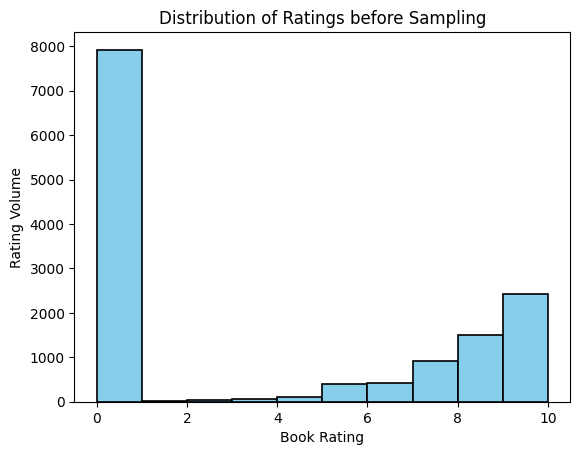

In [23]:
# Plotting the distribution of ratings
import matplotlib.pyplot as plt

# Plotting histogram of ratings
plt.hist(sampled_ratings_df['Book-Rating'], bins=10, color='skyblue', edgecolor='black', linewidth=1.2)
plt.xlabel('Book Rating')
plt.ylabel('Rating Volume')
plt.title('Distribution of Ratings before Sampling')

In [7]:
import torch
import torch.nn as nn

class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, n_factors=20, user_feature_dim=10):
        super().__init__()
        
        # Create user and item embeddings
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)

        # Create user features layer
        self.user_features_layer = nn.Linear(user_feature_dim, n_factors)
        
        # Initialize weights
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.item_factors.weight.data.uniform_(0, 0.05)
        self.user_features_layer.weight.data.uniform_(0, 0.05)
    
    def forward(self, data):
        # Extract user and item IDs
        items = data[:, 0].long()          
        user_ids = data[:, 1].long()       
        user_features = data[:, 2:]
        
        # Lookup of embeddings
        user_embeddings = self.user_factors(user_ids)
        item_embeddings = self.item_factors(items)
        
        # Lookup of user features embeddings
        user_features_embeddings = self.user_features_layer(user_features.float()) 
        
        # Combine user embeddings and user features embeddings
        combined_user_embeddings = user_embeddings + user_features_embeddings 

        # Calculate the interaction between the user and the item
        interaction = (combined_user_embeddings * item_embeddings).sum(dim=1)
        
        return interaction


In [8]:
from torch.utils.data.dataloader import Dataset
from torch.utils.data import DataLoader

class PreProcessor(Dataset):
    def __init__(self, books_df, ratings_df):
        # copy ratings dataframe
        self.ratings = ratings_df.copy()

        # getting all user ids and books isbns
        user_ids = ratings_df['User-ID'].unique()
        book_isbns = books_df['ISBN'].unique()

        # creating dictionaries for mappings
        self.user_to_index = {user: idx for idx, user in enumerate(user_ids)}
        self.book_to_index = {game: idx for idx, game in enumerate(book_isbns)}
        self.index_to_user = {idx: user for user, idx in self.user_to_index.items()}
        self.index_to_book = {idx: game for game, idx in self.book_to_index.items()}

        # mapping user ids and book isbns to indexes
        self.ratings['ISBN'] = ratings_df['ISBN'].apply(lambda x: self.book_to_index[x])
        self.ratings['User-ID'] = ratings_df['User-ID'].apply(lambda x: self.user_to_index[x])

        # creating x and y tensors
        self.x = self.ratings[['ISBN','User-ID','Age']].values
        self.y = self.ratings['Book-Rating'].values

        self.x, self.y = torch.tensor(self.x), torch.tensor(self.y)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [9]:
# setting up hyperparameters
epochs = 250
batch_size = 132
n_factors = 14
book_feature_dim = 1

# seeing if GPU is available
cuda = torch.cuda.is_available()

# create model
model = MatrixFactorization(num_total_users, num_total_books, n_factors, book_feature_dim)
print(model)

if cuda:
    print("Can utilize GPU")
    torch.cuda.empty_cache()
    model = model.cuda()

# print model parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

# loss function and optimizer
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# setting up training data
train_set = PreProcessor(sampled_books_df, sampled_ratings_df)
print("\nTensor head:",train_set[0])
train_loader = DataLoader(train_set, batch_size, shuffle=True)

# recording starting embeddings
initial_book_embeddings = model.item_factors.weight.data.cpu().numpy().copy()

MatrixFactorization(
  (user_factors): Embedding(5334, 14)
  (item_factors): Embedding(99, 14)
  (user_features_layer): Linear(in_features=1, out_features=14, bias=True)
)
user_factors.weight tensor([[0.0468, 0.0251, 0.0124,  ..., 0.0030, 0.0162, 0.0151],
        [0.0049, 0.0106, 0.0414,  ..., 0.0076, 0.0340, 0.0487],
        [0.0170, 0.0252, 0.0435,  ..., 0.0160, 0.0248, 0.0029],
        ...,
        [0.0238, 0.0400, 0.0449,  ..., 0.0132, 0.0078, 0.0429],
        [0.0104, 0.0258, 0.0402,  ..., 0.0410, 0.0330, 0.0137],
        [0.0184, 0.0426, 0.0220,  ..., 0.0204, 0.0384, 0.0226]])
item_factors.weight tensor([[0.0230, 0.0307, 0.0395,  ..., 0.0094, 0.0157, 0.0236],
        [0.0320, 0.0197, 0.0026,  ..., 0.0407, 0.0499, 0.0186],
        [0.0418, 0.0429, 0.0456,  ..., 0.0297, 0.0109, 0.0263],
        ...,
        [0.0064, 0.0025, 0.0389,  ..., 0.0364, 0.0019, 0.0101],
        [0.0107, 0.0110, 0.0268,  ..., 0.0232, 0.0281, 0.0484],
        [0.0068, 0.0161, 0.0117,  ..., 0.0440, 0.0306, 0.

In [10]:
from tqdm.notebook import tqdm_notebook as tqdm 

# matrix factorization training loop
for epoch in tqdm(range(epochs)):
    losses = []

    for x, y in train_loader:
        if cuda:
            x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_func(y_hat.squeeze(), y.type(torch.float32))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, loss: {sum(losses)/len(losses)}')

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 0, loss: 20.58637501852853
Epoch 1, loss: 17.846535682678223
Epoch 2, loss: 17.646955235799155
Epoch 3, loss: 17.48730815705799
Epoch 4, loss: 17.310694449288505
Epoch 5, loss: 17.147813052222844
Epoch 6, loss: 16.97735623859224
Epoch 7, loss: 16.787086305164156
Epoch 8, loss: 16.62190896897089
Epoch 9, loss: 16.390492457435244
Epoch 10, loss: 16.153200585501533
Epoch 11, loss: 15.91341724395752
Epoch 12, loss: 15.650748761494954
Epoch 13, loss: 15.394636608305431
Epoch 14, loss: 15.084893090384346
Epoch 15, loss: 14.791465005420504
Epoch 16, loss: 14.475048710051038
Epoch 17, loss: 14.200687808082217
Epoch 18, loss: 13.8682102112543
Epoch 19, loss: 13.575256611052014
Epoch 20, loss: 13.27343718210856
Epoch 21, loss: 12.985258574712844
Epoch 22, loss: 12.707823299226307
Epoch 23, loss: 12.432339377630324
Epoch 24, loss: 12.143045171101887
Epoch 25, loss: 11.889627892630442
Epoch 26, loss: 11.62332920801072
Epoch 27, loss: 11.37919946398054
Epoch 28, loss: 11.142360523768835
Epoch

In [11]:
# converting factor weights tensor to numpy array
trained_book_embeddings = model.item_factors.weight.data.cpu().numpy()

# Matrix Factorization Heatmap Visualization

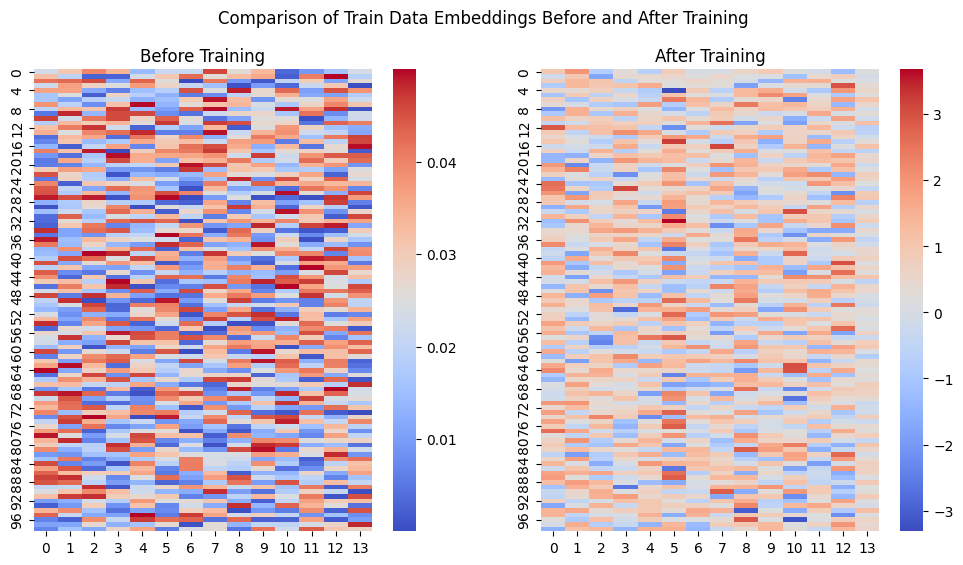

In [12]:
# matrix factorization heatmap
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the heatmap of the original train_data
sns.heatmap(initial_book_embeddings, cmap='coolwarm', ax=axs[0])
axs[0].set_title('Before Training')

# Plot the heatmap of the modified train_data
sns.heatmap(trained_book_embeddings, cmap='coolwarm', ax=axs[1])
axs[1].set_title('After Training')

# Set the overall title for the figure
fig.suptitle('Comparison of Train Data Embeddings Before and After Training')

# Display the plot
plt.show()

# Elbow Method Visualization

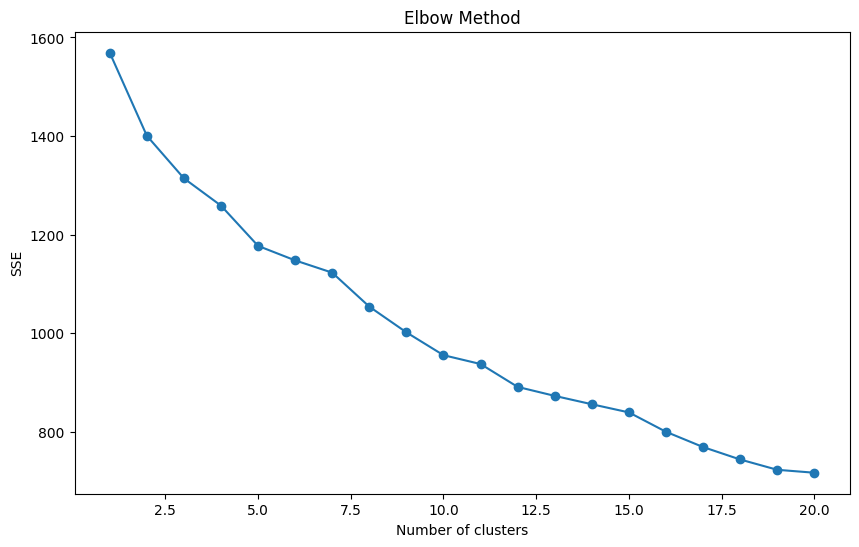

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Determine the optimal number of clusters for K-means clustering
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(trained_book_embeddings)
    sse.append(kmeans.inertia_)

# Plot the number of clusters vs SSE
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')

# Display the plot
plt.show()


# Silhouette Analysis Visualization
- #### Used to identify the optimal number of clusters, distribution of items in the cluster, and overall accuracy

Number of clusters = 2, the average silhouette_score is 0.10120420902967453.
Number of clusters = 3, the average silhouette_score is 0.07012005895376205.
Number of clusters = 4, the average silhouette_score is 0.0682549849152565.
Number of clusters = 5, the average silhouette_score is 0.07783668488264084.
Number of clusters = 6, the average silhouette_score is 0.06697390973567963.
Number of clusters = 7, the average silhouette_score is 0.056848522275686264.
Number of clusters = 8, the average silhouette_score is 0.0756559744477272.
Number of clusters = 9, the average silhouette_score is 0.0830746591091156.


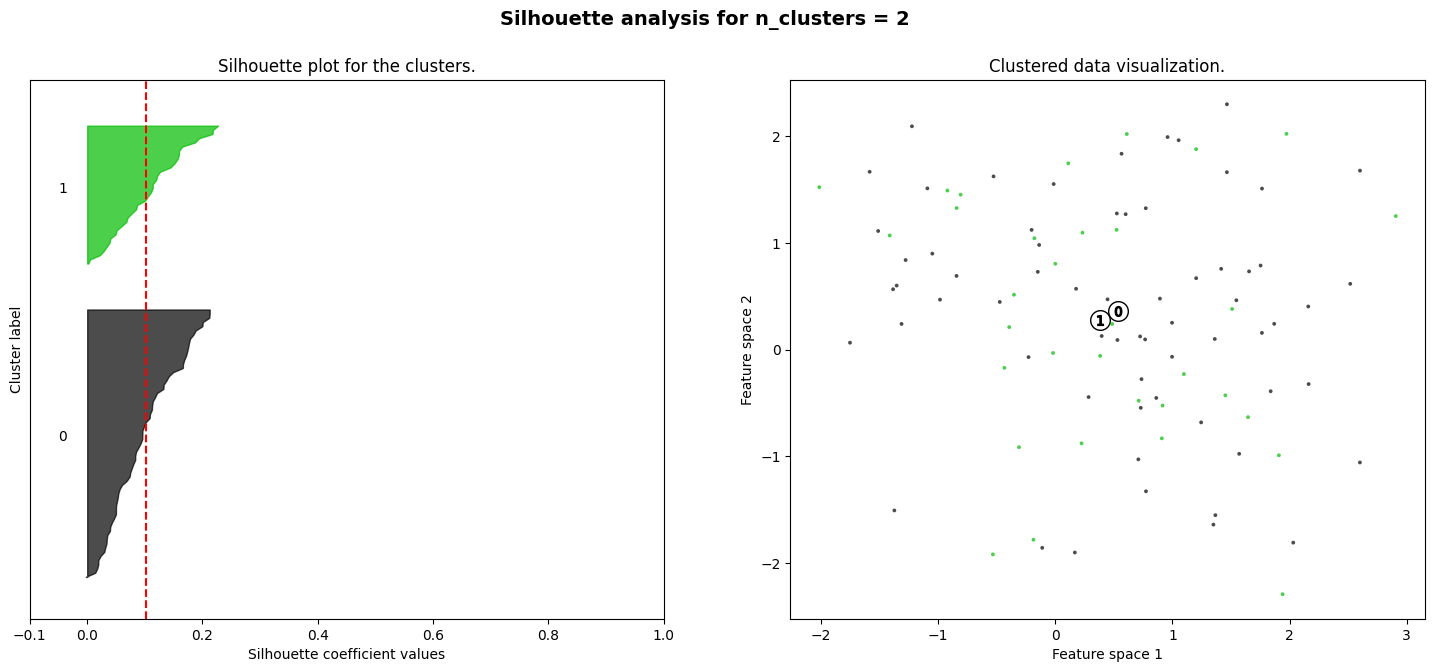

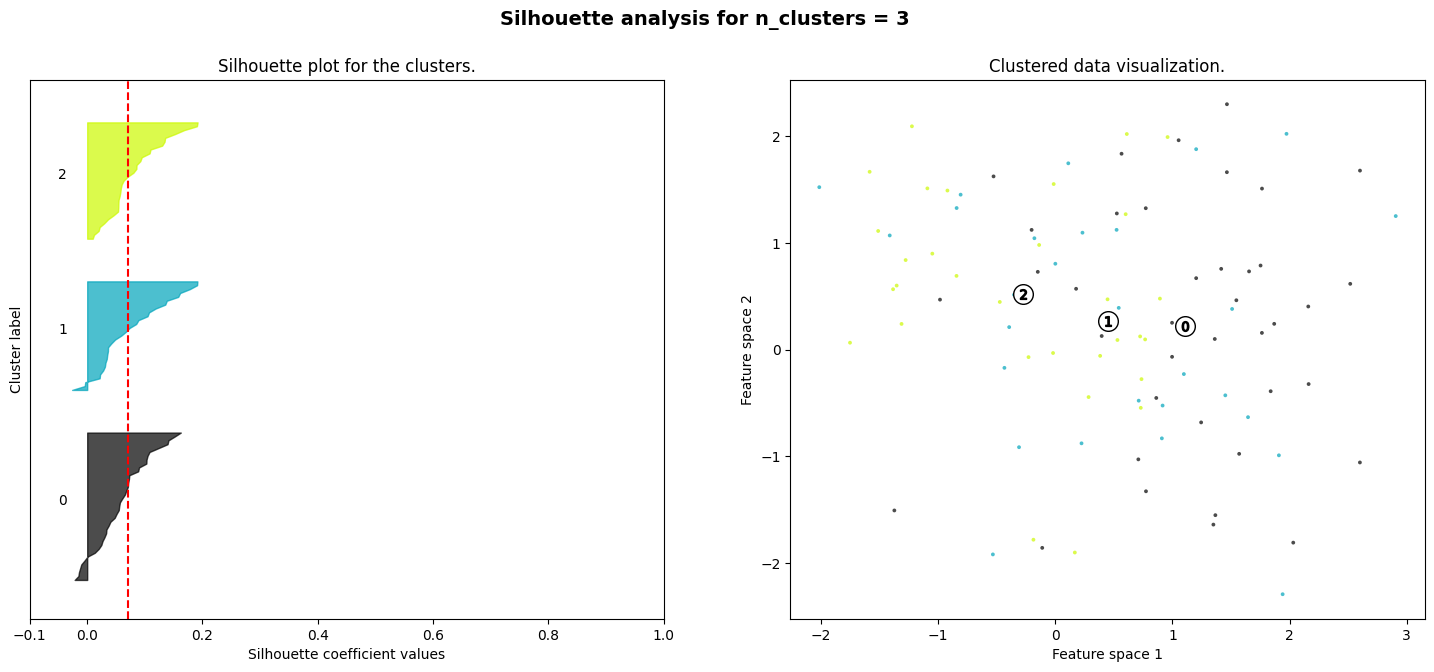

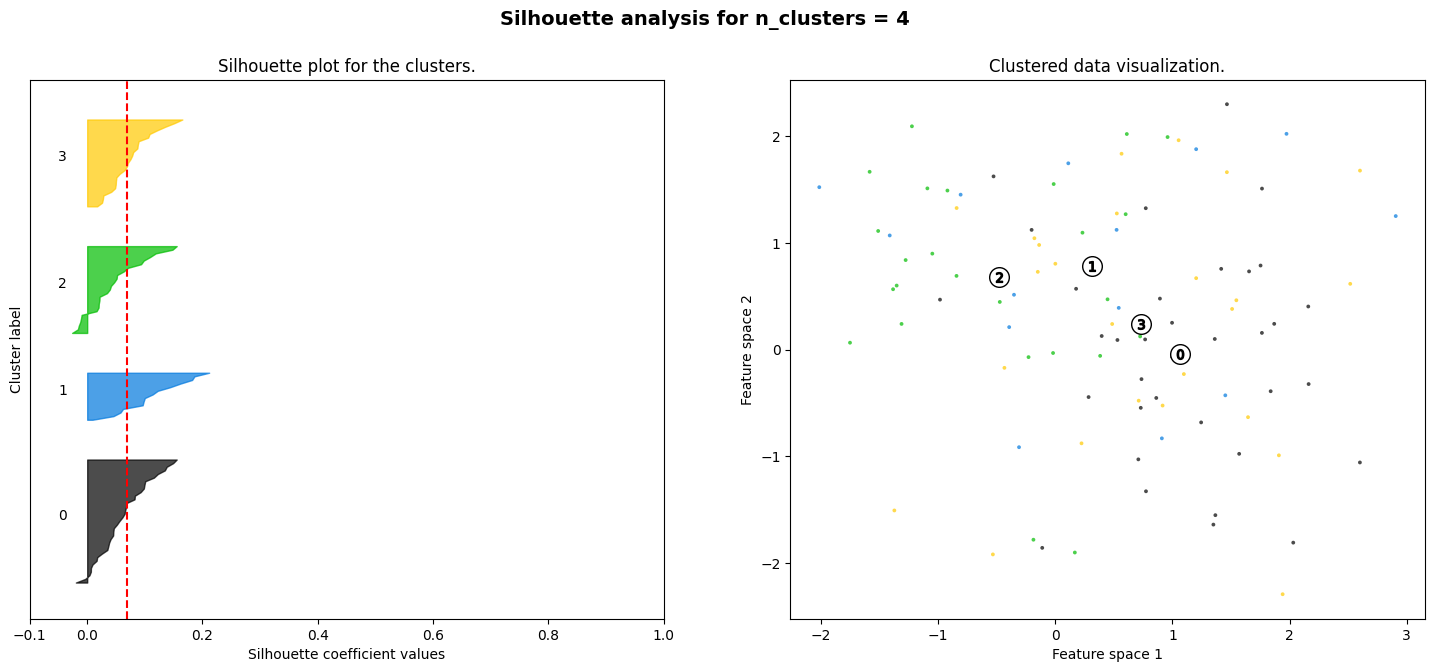

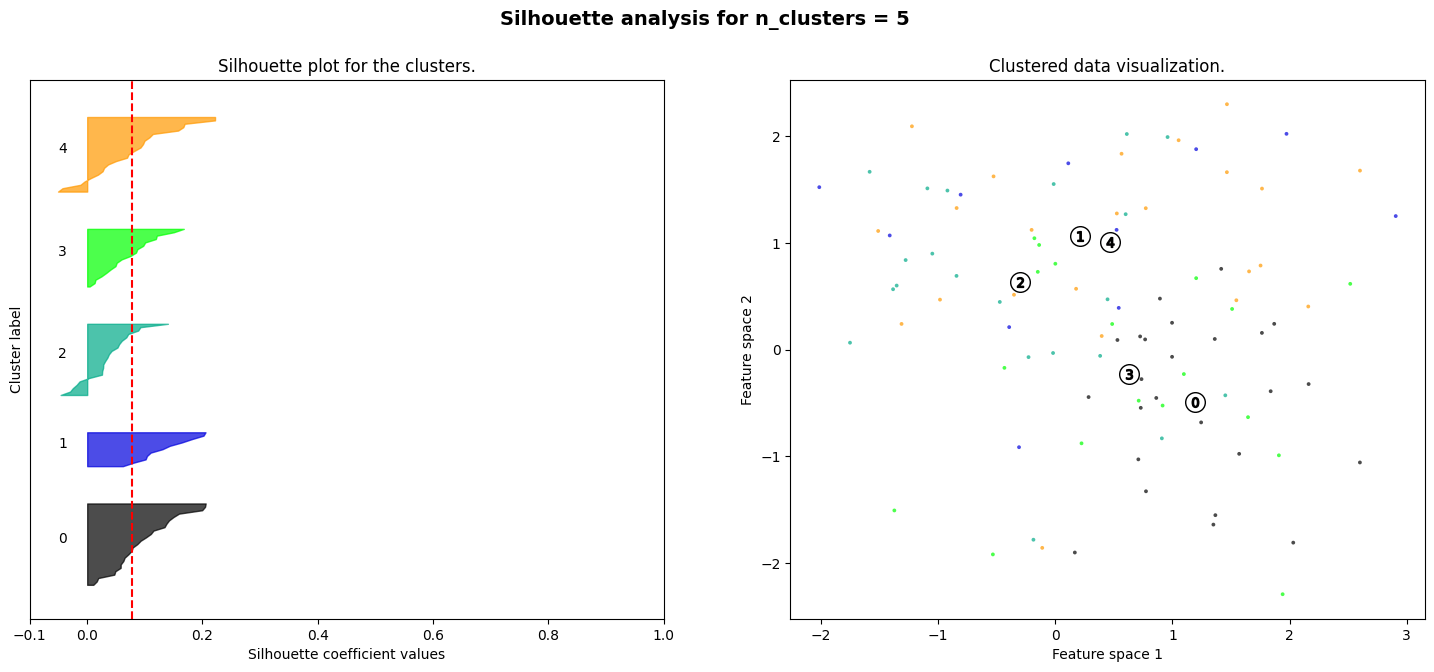

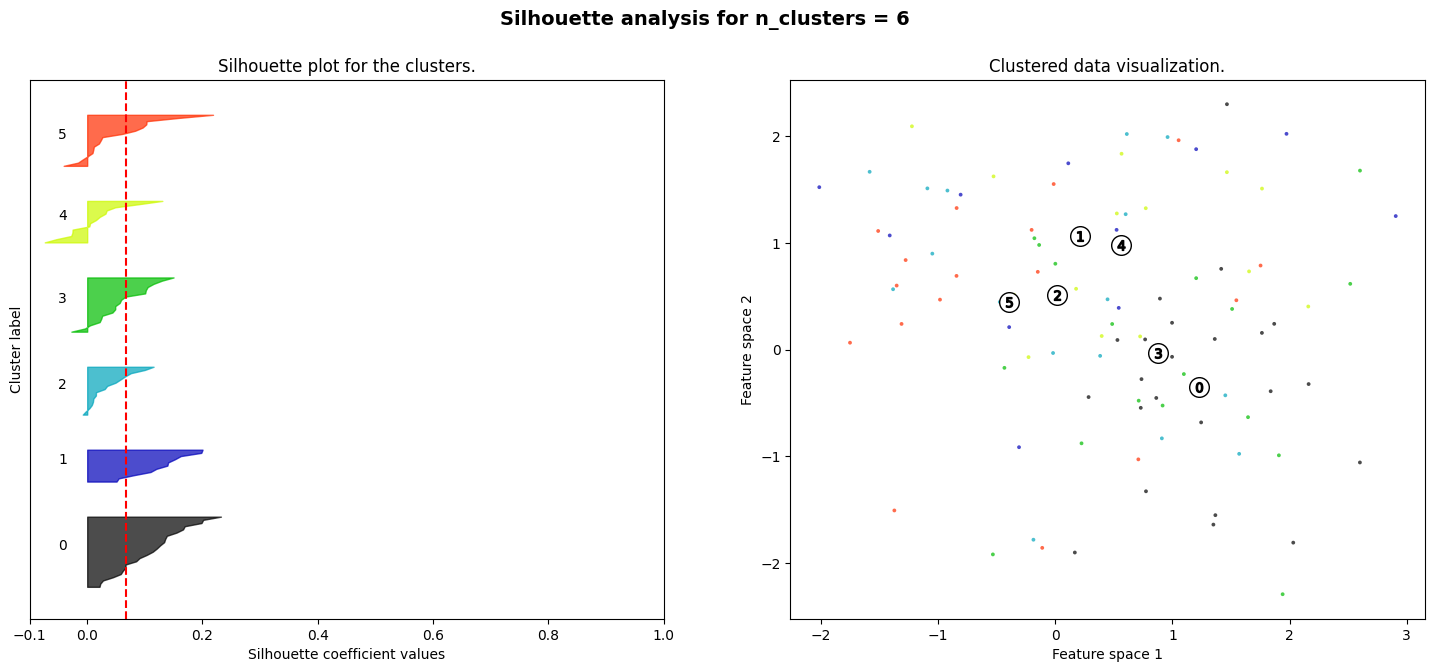

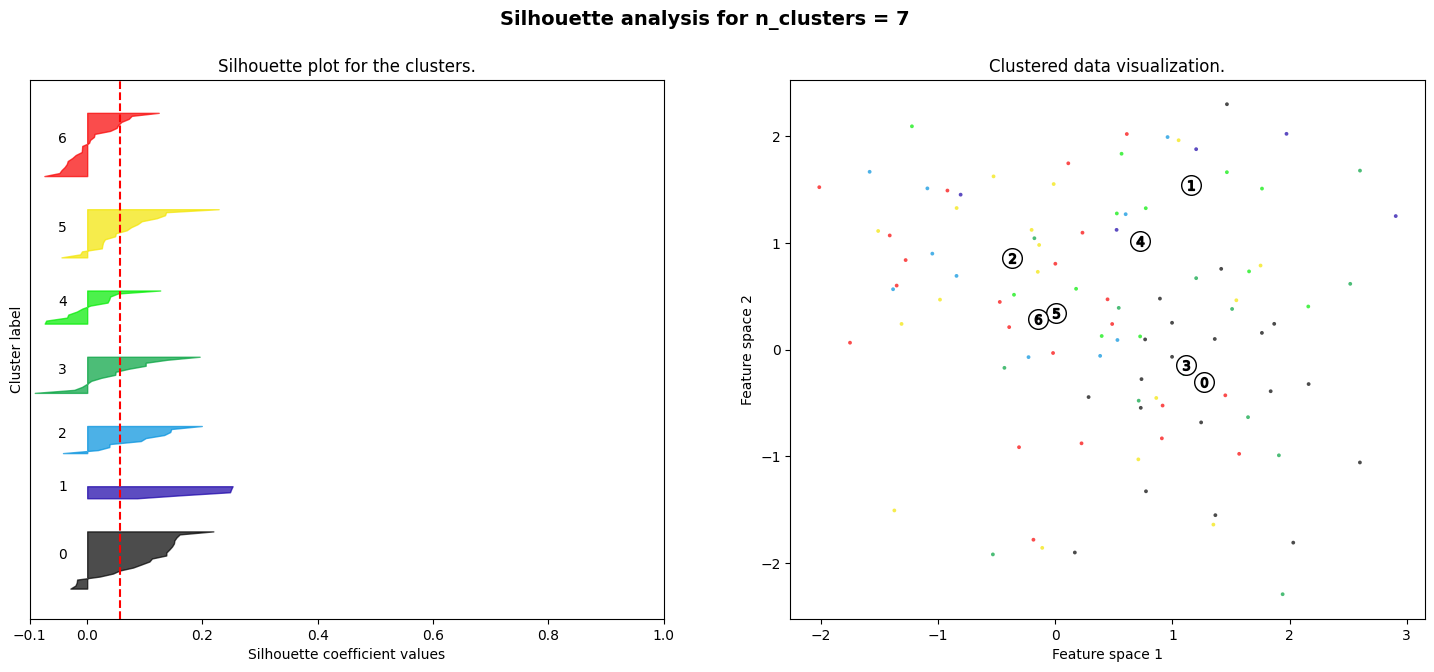

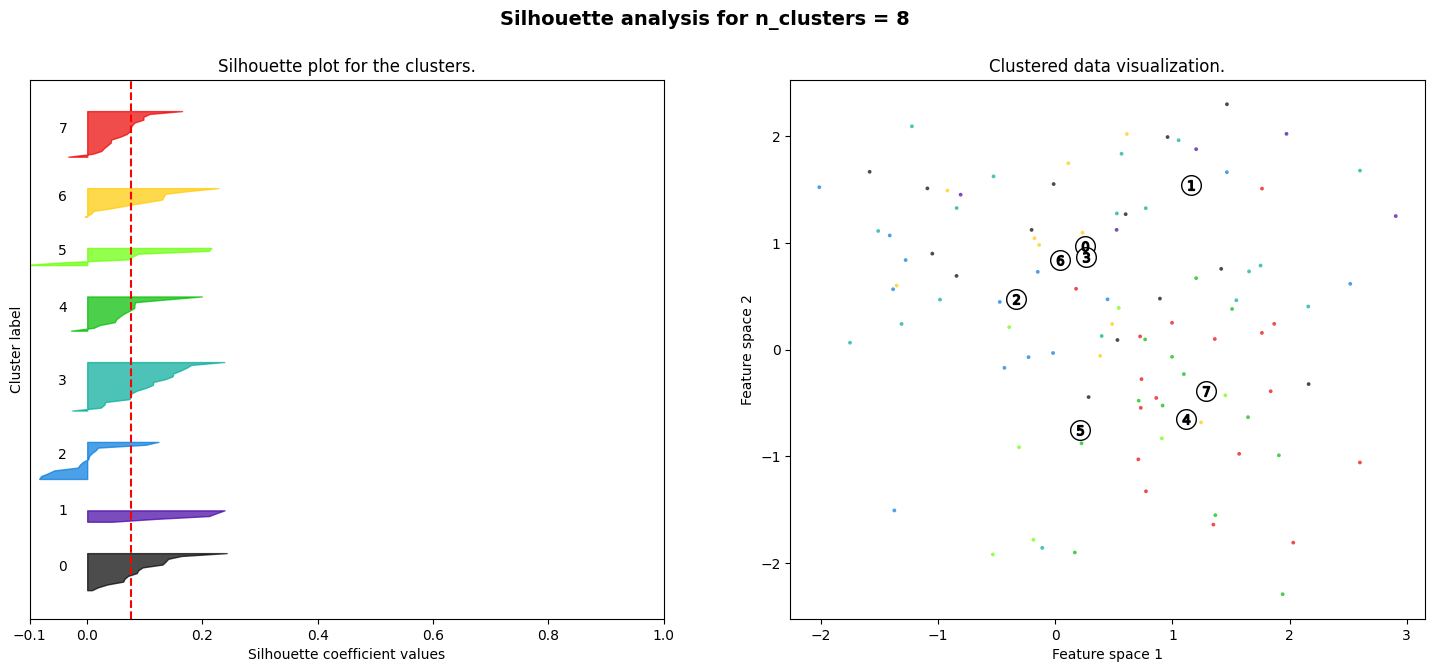

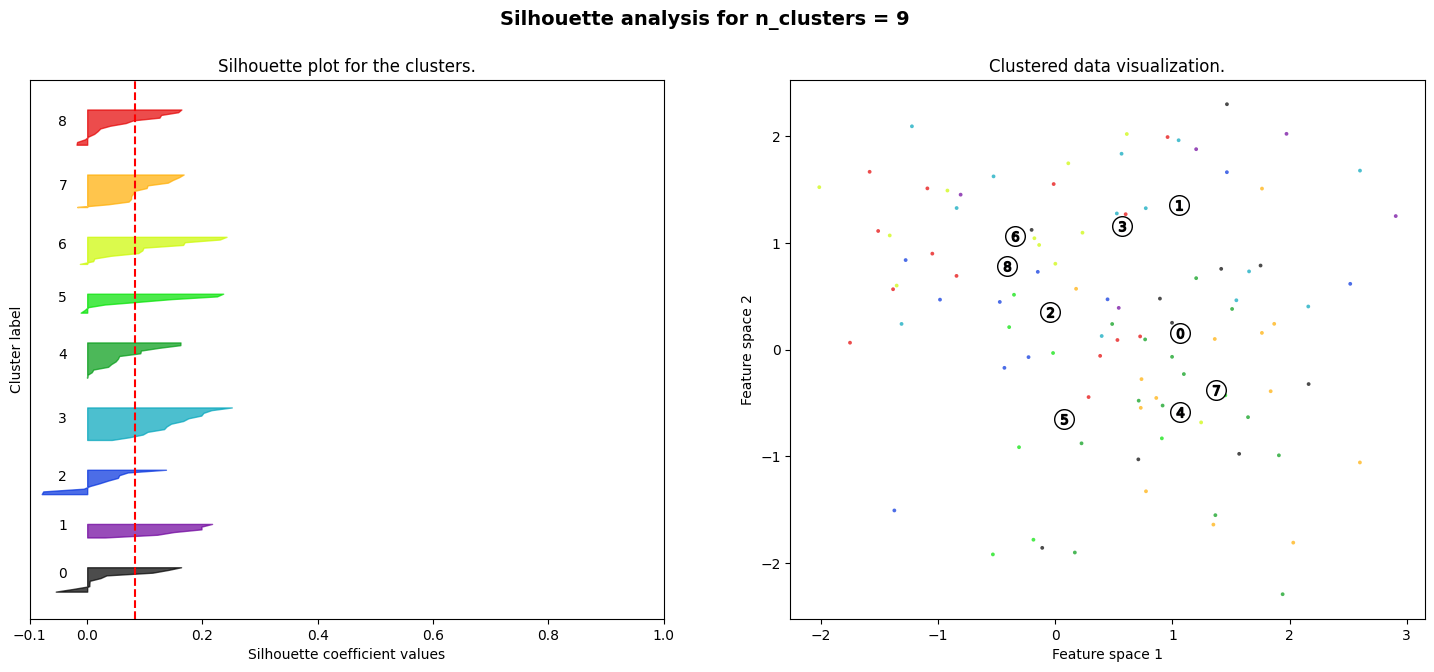

In [14]:
from sklearn.metrics import silhouette_score, silhouette_samples

# creating silhouette plots for different number of clusters
for k in range(2, 10):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(trained_book_embeddings) + (k + 1) * 10])

    clusterer = KMeans(n_clusters=k, random_state=42)
    cluster_labels = clusterer.fit_predict(trained_book_embeddings)

    silhouette_average = silhouette_score(trained_book_embeddings, cluster_labels)
    print(f"Number of clusters = {k}, the average silhouette_score is {silhouette_average}.")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(trained_book_embeddings, cluster_labels)
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax1.set_title("Silhouette plot for the clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_average, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(trained_book_embeddings[:, 0], trained_book_embeddings[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Clustered data visualization.")
    ax2.set_xlabel("Feature space 1")
    ax2.set_ylabel("Feature space 2")

    plt.suptitle(("Silhouette analysis for n_clusters = %d" % k), fontsize=14, fontweight='bold')

plt.show()

In [15]:
from sklearn.cluster import KMeans
number_of_clusters = 4

# fitting kmeans model to trained book embeddings
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42).fit(trained_book_embeddings)

In [16]:
# Initialize a list to hold cluster information
cluster_info = []

# Iterate over clusters
for i in range(number_of_clusters):
    cluster_books = []
    for book_index in np.where(kmeans.labels_ == i)[0]:
        book_ISBN = train_set.index_to_book[book_index]
        cluster_books.append(book_titles[book_ISBN])
    cluster_info.append({'Cluster': f'Cluster {i}', 'Books': '\n'.join(sorted(cluster_books))})

# Print the cluster information in tabular format
print(tabulate(cluster_info, headers='keys', tablefmt='grid'))

+-----------+---------------------------------------------------------------------------+
| Cluster   | Books                                                                     |
+===========+===========================================================================+
| Cluster 0 | A Heartbreaking Work of Staggering Genius                                 |
|           | A Map of the World                                                        |
|           | Along Came a Spider (Alex Cross Novels)                                   |
|           | Cold Mountain : A Novel                                                   |
|           | Confessions of a Shopaholic (Summer Display Opportunity)                  |
|           | Fahrenheit 451                                                            |
|           | Fall On Your Knees (Oprah #45)                                            |
|           | Fast Food Nation: The Dark Side of the All-American Meal                  |
|         

# Cluster Density Visualization
- #### Bar chart of the number of books in each cluster

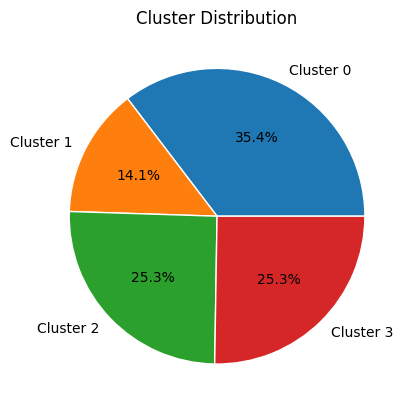

In [17]:
import matplotlib.pyplot as plt

def create_cluster_pie_chart(cluster_labels, cluster_info):
    """
    Creates a pie chart to visualize the distribution of data points in each cluster.

    Parameters:
    - cluster_labels (numpy.ndarray): Array of cluster labels for each data point.
    - cluster_info (list): List of dictionaries containing information about each cluster.

    Returns:
    None
    """

    # Count the number of data points in each cluster
    cluster_counts = [len(cluster_labels[cluster_labels == i]) for i in range(len(cluster_info))]

    # Create a pie chart
    plt.pie(cluster_counts, labels=[cluster['Cluster'] for cluster in cluster_info], autopct='%1.1f%%', wedgeprops=dict(edgecolor='white'))
    plt.title('Cluster Distribution')

    # Display the chart
    plt.show()

# Create a pie chart to visualize the distribution of data points in each cluster
create_cluster_pie_chart(kmeans.labels_, cluster_info)


# K-means Clustering Groups Visualization

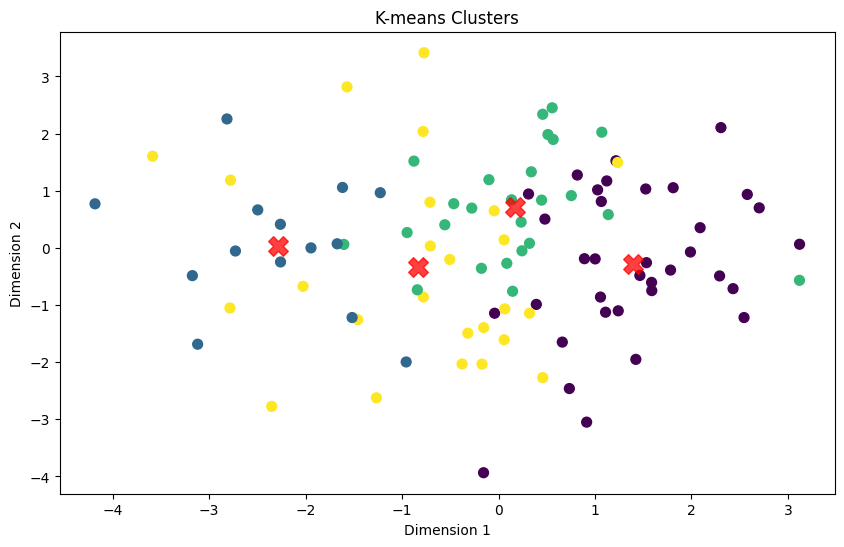

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_clusters(trained_book_embeddings, kmeans):
    """
    Visualizes the clusters generated by K-means algorithm using PCA for dimensionality reduction.

    Parameters:
    trained_book_embeddings (array-like): The trained book embeddings.
    kmeans (KMeans): The trained K-means model.

    Returns:
    None
    """

    # Get the labels assigned by K-means
    y_kmeans = kmeans.labels_

    # Reduce dimensions with PCA for visualization
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(trained_book_embeddings)

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_kmeans, s=50, cmap='viridis')

    # Plot the centroids
    centers_2d = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', s=200, alpha=0.75, marker='X')

    plt.title('K-means Clusters')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

visualize_clusters(trained_book_embeddings, kmeans)


In [19]:
import numpy as np
from ipywidgets import widgets
from IPython.display import display, clear_output

# Create a dropdown widget for selecting a book
book_dropdown = widgets.Dropdown(
    options=book_titles.values(),
    description='Book:',
    disabled=False,
)

# Function to get the cluster of the selected book
def get_book_cluster(unique_book_isbn):
    book_ISBN = sampled_books_df[sampled_books_df['Book-Title'] == unique_book_isbn].iloc[0]['ISBN']
    book_index = train_set.book_to_index[book_ISBN]
    book_embedding = trained_book_embeddings[book_index].reshape(1, -1)
    cluster = kmeans.predict(book_embedding)[0]
    return cluster

# Function to get the books from the same cluster as the selected book
def get_cluster_books(cluster):
    cluster_books = []
    for book_idx in np.where(kmeans.labels_ == cluster)[0]:
        book_name = train_set.index_to_book[book_idx]
        cluster_books.append(book_titles[book_name])
    return cluster_books

# Function to display the books in the same cluster as the selected book
def display_cluster_books(book_title):
    cluster = get_book_cluster(book_title)
    cluster_books = get_cluster_books(cluster)
    clear_output(wait=True)  # Clear previous output
    display(book_dropdown)  # Re-display the dropdown
    print(f'Books from the same cluster {book_title}:')
    for book in cluster_books:
        print(book)

# Create an event handler for the dropdown widget
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        display_cluster_books(change['new'])

# Attach the event handler to the dropdown widget
book_dropdown.observe(on_change, names='value')

# Display the dropdown widget
display(book_dropdown)

Dropdown(description='Book:', options=('The Testament', 'Wild Animus', 'Timeline', 'To Kill a Mockingbird', 'T…

In [20]:
# write all cells to a file
#!jupyter nbconvert --to script WGU_Capstone.ipynb